In [31]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt

# Load data
print('Loading data...')
crime_df = pd.read_csv('data/Crimes_-_2001_to_2021.csv')
print('Loaded the data!')

# Cleaning dataframe
crime_df.drop(columns=['Case Number','Block','IUCR','Primary Type', # IUCR of Primary Type ?
                        'Description','Location Description','Arrest', # Location Description voor LSTM ?
                        'Domestic','Beat','District','Ward','Community Area', # Community Are voor visualisatie
                        'FBI Code','Updated On','Location'], inplace=True)
crime_df = crime_df.rename(columns={'X Coordinate':'x', 'Y Coordinate':'y'})
crime_df.dropna(inplace=True)

# Extract last month of data
print('Converting to datetime column')
month_crime_df = crime_df.loc[crime_df['Year'] == 2021]
month_crime_df['Date'] = pd.to_datetime(month_crime_df['Date'])
month_crime_df = month_crime_df.loc[crime_df['Date'] > '11/31/2021']
print('Done.')

Loading data...
Loaded the data!
Converting to datetime column


C:\Users\Ruben\AppData\Local\Temp\ipykernel_9764\1704907568.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_crime_df['Date'] = pd.to_datetime(month_crime_df['Date'])


Done.


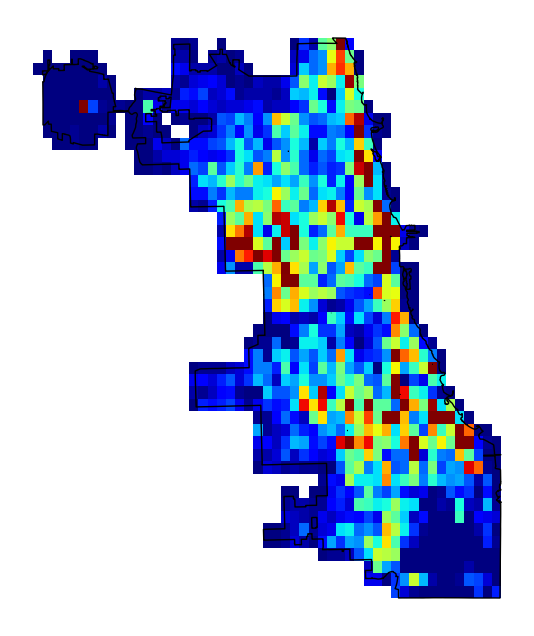

In [32]:
path = 'data/shapefile/geo_export.shp'
chicago = gpd.read_file(path)
chicago = chicago.dissolve()

crs = "EPSG:4326"
gdf = gpd.GeoDataFrame(month_crime_df, geometry=gpd.points_from_xy(month_crime_df.Longitude, month_crime_df.Latitude), crs=crs)

xmin, ymin, xmax, ymax = chicago.total_bounds
n_x_cells = 50
x_cell_size = (xmax - xmin) / n_x_cells
n_y_cells = round(((ymax - ymin)/(xmax - xmin))*n_x_cells)
y_cell_size = (ymax - ymin) / n_y_cells
grid_cells = []
for x0 in np.arange(xmin, xmax+x_cell_size, x_cell_size):
    for y0 in np.arange(ymin, ymax+y_cell_size, y_cell_size):
        x1 = x0-x_cell_size
        y1 = y0+y_cell_size
        box = shapely.geometry.box(x0, y0, x1, y1)
        if chicago.intersection(box).any():
            grid_cells.append(box)
            
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

merged = gpd.sjoin(gdf, cell, how='left', predicate='within')
merged['n_crimes'] = 0
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell['n_crimes'] = 0
cell.loc[dissolve.index, 'n_crimes'] = dissolve.n_crimes.values

vmax = cell.n_crimes.mean() + 2*cell.n_crimes.std()
ax = cell.plot(column='n_crimes', figsize=(12, 8), vmax=vmax, cmap='jet', edgecolor=None)
chicago.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

plt.show()

# Creating the mask matrix and a mask column and applying it to the dataframe

In [33]:
xmin, ymin, xmax, ymax = chicago.total_bounds
n_cells = 1000
n_x_cells = n_y_cells = round(np.sqrt(n_cells))
x_cell_size, y_cell_size = (xmax - xmin) / n_x_cells, (ymax - ymin) / n_y_cells

mask = np.ones((n_x_cells, n_x_cells))
grid = {"mask":[], "geometry":[]}
for i in range(mask.shape[0]):
    x0 = i * x_cell_size + xmin
    x1 = x0 + x_cell_size
    for j in range(mask.shape[1]):
        y0 = j * y_cell_size + ymin
        y1 = y0 + y_cell_size
        box = shapely.geometry.box(x0, y0, x1, y1)
        if not chicago.intersection(box).any():
            mask[-j-1,i] = 0
            grid["mask"].append(0)
        else:
            grid["mask"].append(1)
        grid["geometry"].append(box)

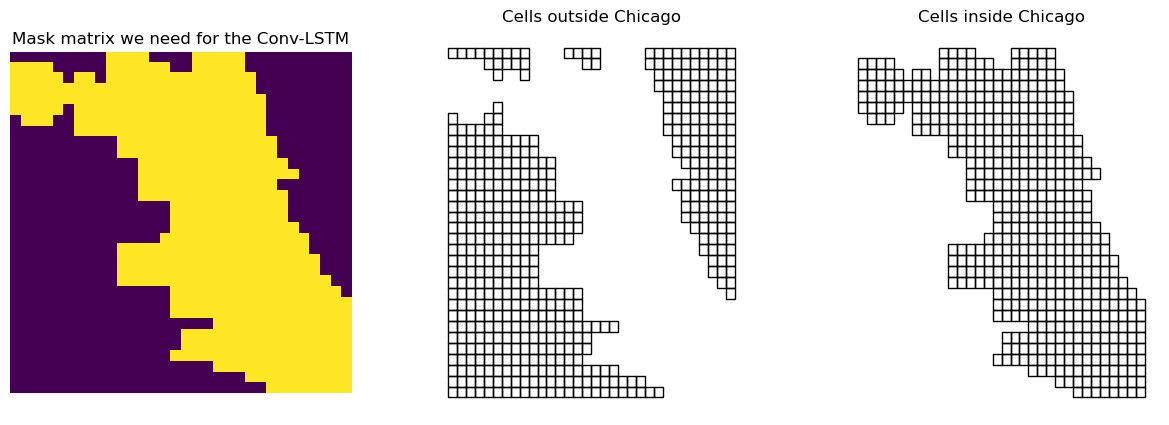

In [34]:
grid_df = gpd.GeoDataFrame(grid, crs=crs)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))


ax[0].imshow(mask)
ax[0].set_title("Mask matrix we need for the Conv-LSTM")
ax[0].axis("off")

# plot cells that are not in chicago
grid_df.loc[grid_df['mask'] == 0].plot(ax=ax[1], color='none', edgecolor='black')
ax[1].set_title("Cells outside Chicago")
ax[1].axis("off")

# plot cells that are in chicago
grid_df.loc[grid_df['mask'] == 1].plot(ax=ax[2], color='none', edgecolor='black')
ax[2].set_title("Cells inside Chicago")
ax[2].axis("off")
plt.show()

### Example: lstm predicts crimes outside of city, mask removes prediction

C:\Users\Ruben\AppData\Local\Temp\ipykernel_9764\480910405.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_df['n_crimes'][random_locations] = 100


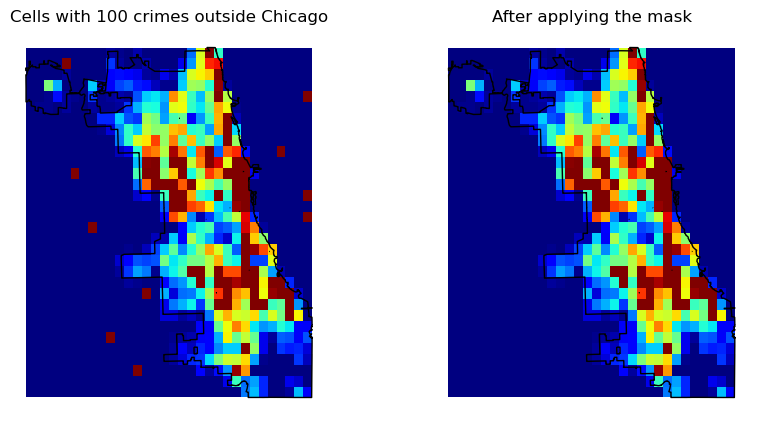

In [35]:
merged = gpd.sjoin(gdf, grid_df, how='left', predicate='within')
merged['n_crimes'] = 0
dissolve = merged.dissolve(by="index_right", aggfunc="count")
grid_df['n_crimes'] = 0
grid_df.loc[dissolve.index, 'n_crimes'] = dissolve.n_crimes.values
vmax = grid_df.n_crimes.mean() + 2*grid_df.n_crimes.std()

# set 10 random cells outside of chicago to 100 crimes
random_locations = grid_df.loc[grid_df['mask'] == 0].sample(10, random_state=42).index
grid_df['n_crimes'][random_locations] = 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0] = grid_df.plot(ax=ax[0], column='n_crimes', figsize=(12, 8), vmax=vmax, cmap='jet', edgecolor=None)
chicago.plot(ax=ax[0], color='none', edgecolor='black')
ax[0].axis('off')
ax[0].set_title("Cells with 100 crimes outside Chicago")

# apply the mask
grid_df['n_crimes'] = grid_df['n_crimes'] * grid_df['mask']

ax[1] = grid_df.plot(ax=ax[1], column='n_crimes', figsize=(12, 8), vmax=vmax, cmap='jet', edgecolor=None)
chicago.plot(ax=ax[1], color='none', edgecolor='black')
ax[1].axis('off')
ax[1].set_title("After applying the mask")

plt.show()
